In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint
import torch.optim as optim
from scipy.stats import qmc

In [2]:
import sys
print(sys.version)

3.9.13 (v3.9.13:6de2ca5339, May 17 2022, 11:37:23) 
[Clang 13.0.0 (clang-1300.0.29.30)]


### Create a gLV model and simulate

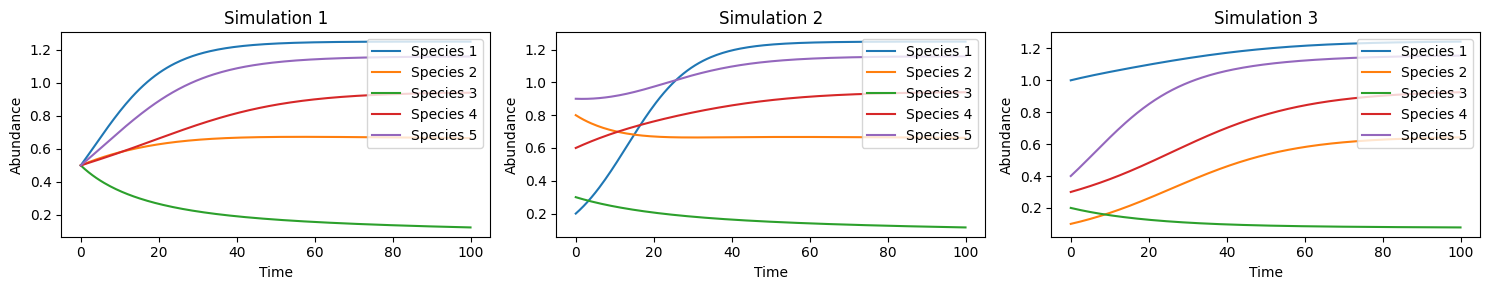

In [3]:
# GLV model function
class GLVModel(torch.nn.Module):
    def __init__(self, r, A):
        super().__init__()
        self.r = r
        self.A = A

    def forward(self, t, x):
        return x * (self.r + torch.matmul(self.A, x))

# Fixed model parameters
n_species = 5
r = torch.tensor([0.1, 0.05, -0.02, 0.03, 0.07])  # growth rates
A = torch.tensor([
    [-0.1,  0.02, 0.00,  0.00,  0.01],
    [ 0.01, -0.1, 0.03,  0.00,  0.00],
    [ 0.00, 0.01, -0.08, 0.02,  0.00],
    [ 0.00, 0.00, 0.01, -0.07, 0.03],
    [ 0.02, 0.00, 0.00,  0.01, -0.09]
]) # interaction matrix
glv_model = GLVModel(r, A)

# Time points
t = torch.linspace(0, 100, 200)

# Initial conditions
initial_conditions = torch.tensor([
    [0.5, 0.5, 0.5, 0.5, 0.5],
    [0.2, 0.8, 0.3, 0.6, 0.9],
    [1.0, 0.1, 0.2, 0.3, 0.4]
])

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharex=True)

# Run and plot each simulation
for i, x0 in enumerate(initial_conditions):
    sol = odeint(glv_model, x0, t)
    for j in range(n_species):
        axs[i].plot(t, sol[:, j], label=f'Species {j+1}')
    axs[i].set_ylabel('Abundance')
    axs[i].set_xlabel('Time')
    axs[i].set_title(f'Simulation {i+1}')
    axs[i].legend(loc='upper right')
plt.tight_layout()

### Generate training and testing data

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Time points
t = torch.arange(0,20.5,0.5)

# Store all results
all_data = []

# Generate 1000 initial conditions
sampler = qmc.LatinHypercube(d=n_species)
initial_conditions = sampler.random(n=1000)

# Run 1000 simulations with sampled initial conditions
for sim_id in range(1000):
    # x0 = torch.rand(n_species)
    x0 = torch.from_numpy(initial_conditions[sim_id]).float() # convert torch.float64(Double) to torch.float32(Float)
    sol = odeint(glv_model, x0, t)
    df = pd.DataFrame(sol, columns=[f"species_{i+1}" for i in range(n_species)])
    df["time"] = t
    df["sim_id"] = sim_id
    all_data.append(df)

# Combine all simulations into one DataFrame
df_full = pd.concat(all_data, ignore_index=True)

# Sample 50% of simulated data
# Each curve may include different number of data points
df_sampled = df_full.sample(frac=0.5, random_state=42).reset_index(drop=True)

# Sort rows and reorder columns
df_sampled = df_sampled.sort_values(['sim_id','time']).reset_index(drop=True)
cols = ["sim_id", "time"] + [f"species_{i+1}" for i in range(n_species)]
df_sampled = df_sampled[cols]
df_sampled.head()

,sim_id,time,species_1,species_2,species_3,species_4,species_5
0,0,0.0,0.605807,0.853970,0.761992,0.327574,0.747877
1,0,0.5,0.625198,0.851152,0.737685,0.333673,0.754639
2,0,1.5,0.663938,0.845278,0.693387,0.345975,0.768164
3,0,2.0,0.683212,0.842263,0.673152,0.352178,0.774924
4,0,3.0,0.721384,0.836161,0.635997,0.364688,0.788431


In [5]:
# Get unique simulation IDs
unique_ids = df_sampled['sim_id'].unique()
np.random.shuffle(unique_ids)

# Split the IDs into 70% train and 30% test
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

# Filter the DataFrame based on the sim_id
df_train = df_sampled[df_sampled['sim_id'].isin(train_ids)].reset_index(drop=True)
df_test = df_sampled[df_sampled['sim_id'].isin(test_ids)].reset_index(drop=True)

# Confirm the split
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (14383, 7)
Test shape: (6117, 7)


### Train a neural ODE model

In [6]:
# Define Neural ODE model
class ODEF(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, dim)
        )
        self.init_weights()

    def init_weights(self):
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # He initialization
                nn.init.zeros_(m.bias) # set Bias to 0

    def forward(self, t, y):
        return self.net(y)

In [7]:
# Group simulated data into (t,y) pairs
species_columns = ['species_1', 'species_2', 'species_3', 'species_4', 'species_5']
def group_by_sim(df):
    grouped = []
    for sim_id, group in df.groupby('sim_id'):
        t = torch.tensor(group['time'].values, dtype=torch.float32)
        y = torch.tensor(group[species_columns].values, dtype=torch.float32)
        grouped.append((t, y))
    return grouped

train_curves = group_by_sim(df_train)
test_curves = group_by_sim(df_test)

# Confirm the grouping
print("Train shape:", len(train_curves))
print("Test shape:", len(test_curves))

Train shape: 700
Test shape: 300


In [8]:
# Training Setup
odefunc = ODEF(dim=5)
optimizer = optim.RMSprop(odefunc.parameters(), lr=1e-4)
criterion = nn.MSELoss()
n_epochs = 1000
batch_size = 8  # number of curves per batch
train_losses = []
test_losses = []

# Training Loop
for epoch in range(n_epochs):
    np.random.shuffle(train_curves)

    # Model training
    train_loss = 0
    for i in range(0, len(train_curves), batch_size):
        batch = train_curves[i:i+batch_size]
        loss = 0
        for t, y in batch:
            y0 = y[0]
            pred_y = odeint(odefunc, y0, t)
            loss += criterion(pred_y, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    train_loss /= len(train_curves)
    train_losses.append(train_loss)

    # Evaluate on test data
    with torch.no_grad():
        test_loss = 0
        for t, y in test_curves:
            y0 = y[0]
            pred_y = odeint(odefunc, y0, t)
            test_loss += criterion(pred_y, y).item()
        test_loss /= len(test_curves)
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}")

Epoch 1: Train Loss = 30.3572, Test Loss = 19.8389
Epoch 2: Train Loss = 14.7470, Test Loss = 12.0802
Epoch 3: Train Loss = 9.4163, Test Loss = 7.4966
Epoch 4: Train Loss = 5.8692, Test Loss = 4.1215
Epoch 5: Train Loss = 2.9974, Test Loss = 2.0679
Epoch 6: Train Loss = 1.7346, Test Loss = 1.4657
Epoch 7: Train Loss = 1.2910, Test Loss = 1.1043
Epoch 8: Train Loss = 0.9610, Test Loss = 0.8037
Epoch 9: Train Loss = 0.6740, Test Loss = 0.5354
Epoch 10: Train Loss = 0.4613, Test Loss = 0.3767
Epoch 11: Train Loss = 0.3393, Test Loss = 0.2784
Epoch 12: Train Loss = 0.2644, Test Loss = 0.2226
Epoch 13: Train Loss = 0.2141, Test Loss = 0.1870
Epoch 14: Train Loss = 0.1844, Test Loss = 0.1658
Epoch 15: Train Loss = 0.1666, Test Loss = 0.1523
Epoch 16: Train Loss = 0.1529, Test Loss = 0.1397
Epoch 17: Train Loss = 0.1412, Test Loss = 0.1286
Epoch 18: Train Loss = 0.1292, Test Loss = 0.1173
Epoch 19: Train Loss = 0.1175, Test Loss = 0.1066
Epoch 20: Train Loss = 0.1054, Test Loss = 0.0945
Epoch

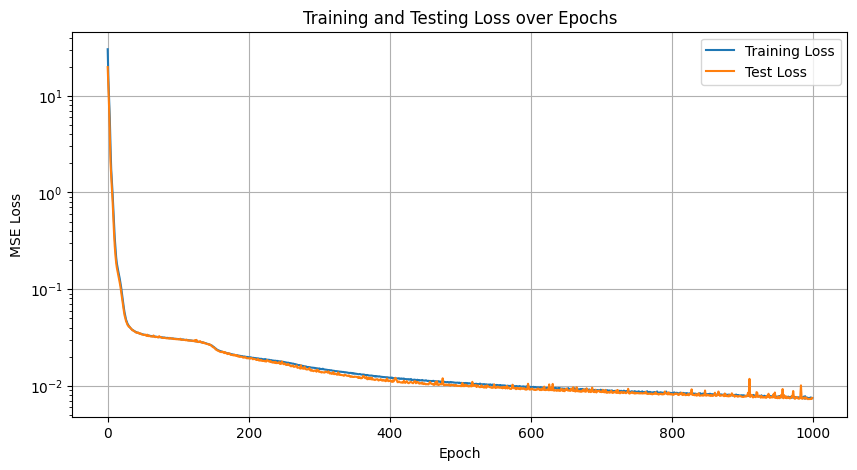

In [9]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.grid(True)
plt.yscale('log')

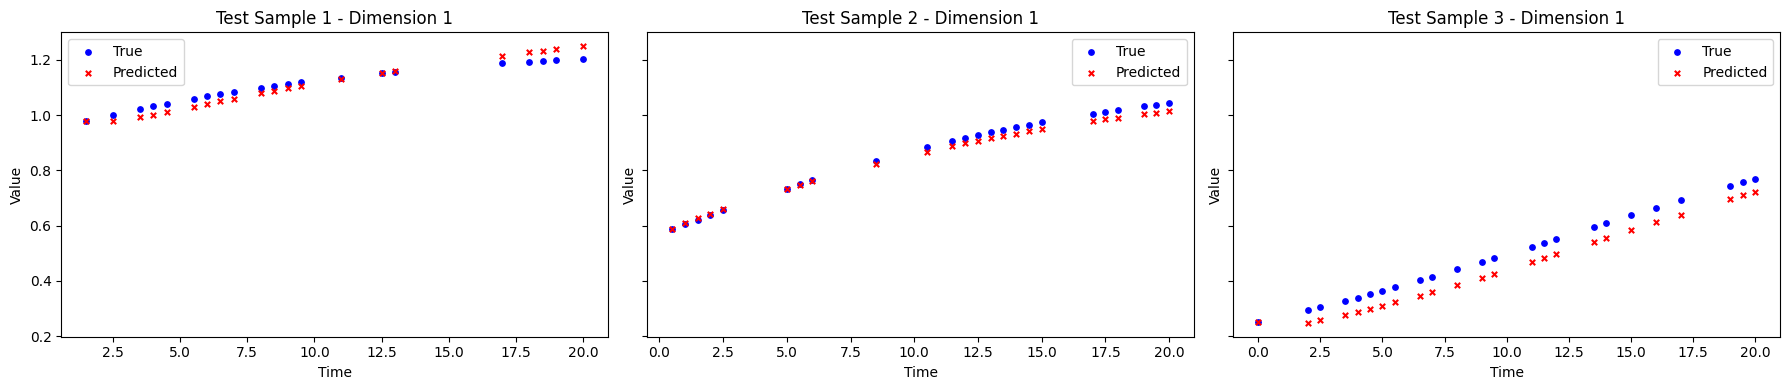

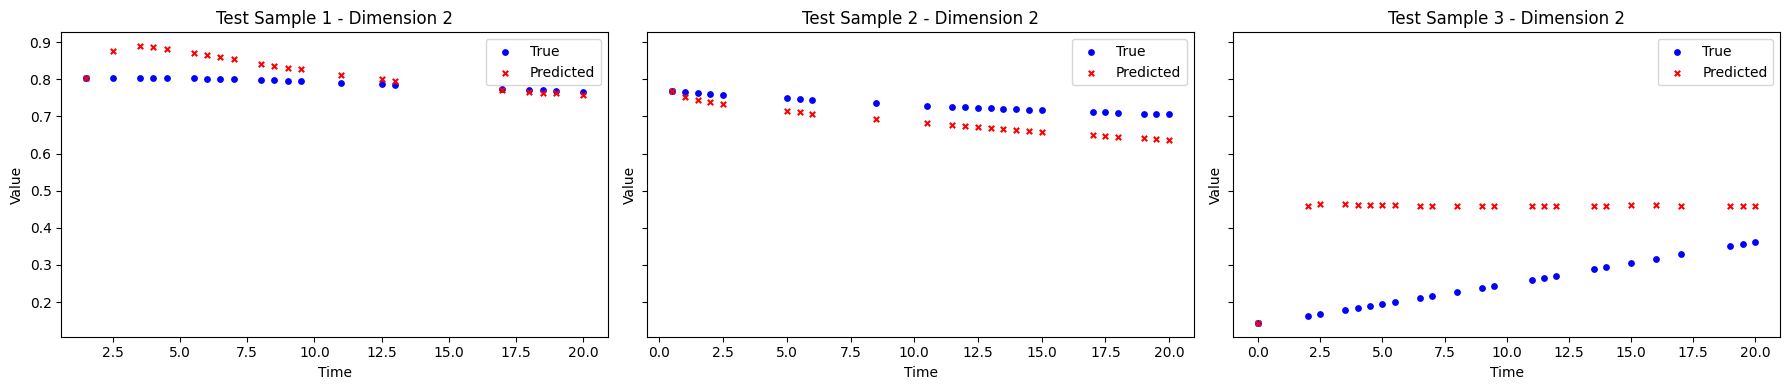

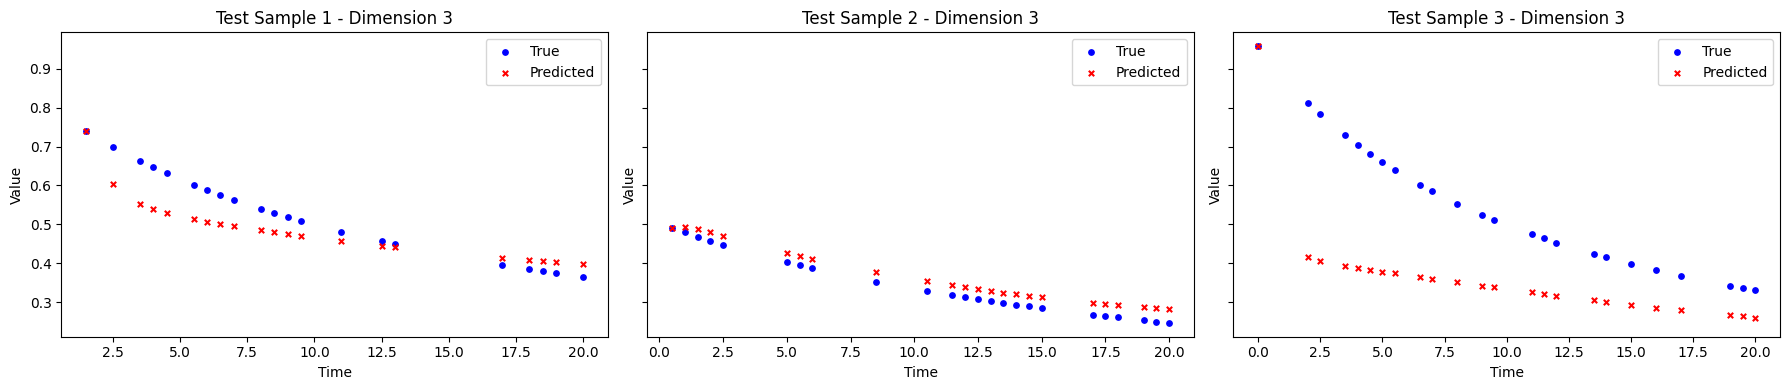

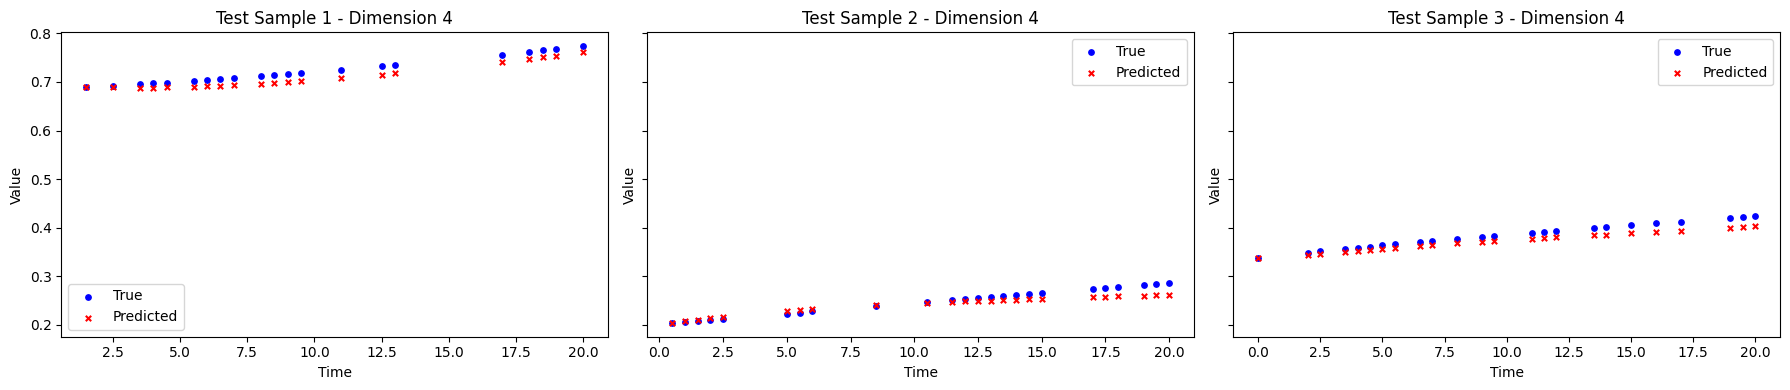

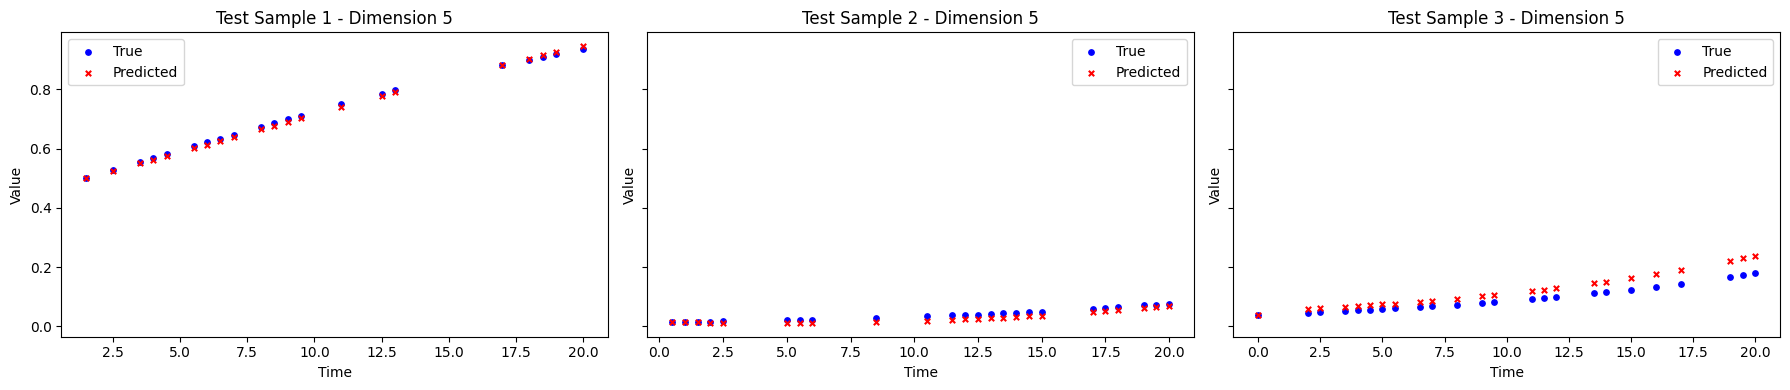

In [10]:
# Scatter plot of test curve prediction
with torch.no_grad():
    for dim in range(test_curves[0][1].shape[1]):  # Loop over each dimension
        fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)  # 1 row, 3 columns of subplots

        for idx, (t, y_true) in enumerate(test_curves[:3]):  # First 3 test curves
            y0 = y_true[0]
            y_pred = odeint(odefunc, y0, t)

            ax = axes[idx]
            ax.scatter(t.cpu(), y_true[:, dim].cpu(), label='True', color='blue', s=15)
            ax.scatter(t.cpu(), y_pred[:, dim].cpu(), label='Predicted', color='red', marker='x', s=15)
            ax.set_title(f'Test Sample {idx+1} - Dimension {dim+1}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.legend()

        plt.tight_layout()

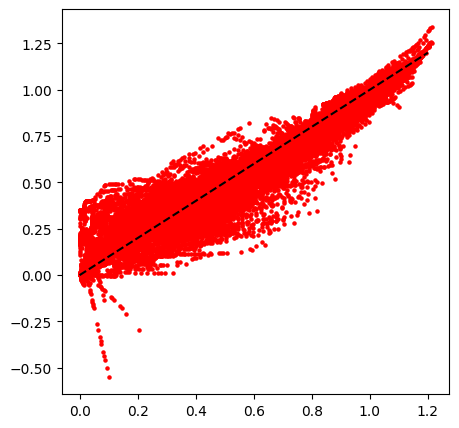

In [11]:
# Scatter plot and R2
with torch.no_grad():
    y_true_all = []
    y_pred_all = []
    for t, y_true in test_curves:
        y0 = y_true[0]
        y_pred = odeint(odefunc, y0, t)
        y_true_all.extend(y_true.reshape(-1).tolist())
        y_pred_all.extend(y_pred.reshape(-1).tolist())

plt.figure(figsize=(5,5))
plt.scatter(y_true_all, y_pred_all, s=5, color='r')
plt.plot([0,1.2],[0,1.2],'k--')